## Import Dependencies

In [15]:
# List of external libraries used:
# pandas: https://pandas.pydata.org
# numpy: https://numpy.org
# matplotlub: https://matplotlib.org
# sklearn: https://scikit-learn.org

In [ ]:
!nvidia-smi

## Import Drive (Google Colab only)

In [17]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Go to the model directory
os.chdir("drive/My Drive/Colab Notebooks/CMPT419Project/model")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AvgPool2D, Input, concatenate, Activation
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mean_squared_error, RootMeanSquaredError

from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

In [ ]:
W = 64
H = 64

# Preprocessing:

## Landmarks detection

In [ ]:
import dlib

predictor = dlib.shape_predictor('../Dataset/utils/shape_predictor_68_face_landmarks.dat')

def get_landmarks_as_face(face):
    landmarks = predictor(face, dlib.rectangle(0,0,W-1,H-1))
    landmarks_image = np.zeros((W,H,1))
    for i in range(0, 68):
        cv2.circle(landmarks_image, (landmarks.part(i).x, landmarks.part(i).y), 1, 255, -1)
  
    return landmarks_image

## Load the dataset

In [32]:
import h5py

filename = "../Dataset/facial_data.h5"

rand = []
train_data = []
test_data = []
test_keys = []

# Getting 50 random test frames
for rand_num in np.random.randint(1, 601, 50):
  if(rand_num < 10): rand.append('00' + str(rand_num) + '_')
  elif(rand_num < 100): rand.append('0' + str(rand_num) + '_')
  else: rand.append(str(rand_num) + '_')

with h5py.File(filename, "r") as f:
    keys = list(f.keys())
    # Get the data
    i = 0
    for key in keys:

      img = cv2.resize(np.array(f[key]), (W,H))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      if(key[0:4] in rand):
        test_keys.append(key)

        test_data.append(img)
        continue

      train_data.append(img)
      i = i+1

train_data = np.array(train_data)

test_data = np.array(test_data)

df = pd.read_csv('../Dataset/label_data.csv')

df_test = df[df['file_name'].isin(test_keys)]

df_train = df[df['file_name'].isin(keys)]
df_train = df_train[~df_train['file_name'].isin(test_keys)]

train_targets = df_train[['arousal', 'valence']].values

unique_targets_df = df_train.drop_duplicates(subset=['arousal', 'valence'])
unique_targets = unique_targets_df[['arousal', 'valence']].values

test_targets = df_test[['arousal', 'valence']].values/10.0

# Load test dataset

for filename in os.listdir('../Dataset/game_data'):
  if filename.endswith("png"):
    img = cv2.imread('../Dataset/game_data/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W,H))
    test_data.append(img)

test_data = np.array(test_data)

df = pd.read_csv('../Dataset/game_data/Mixed_annotate.csv')
test_targets = np.concatenate([test_targets, df[['Arousal', 'Valence']].values], axis=0)

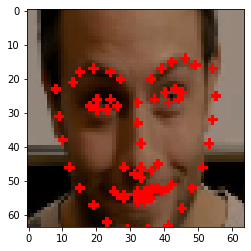

In [ ]:
# Sample visualization
landmarks = predictor(train_data[10], dlib.rectangle(0,0,63,63))
for i in range(0, 68):
  cv2.circle(train_data[10], (landmarks.part(i).x, landmarks.part(i).y), 1, (255,0,0), -1)
  
plt.imshow(train_data[10])

<AxesSubplot:xlabel='arousal', ylabel='count'>

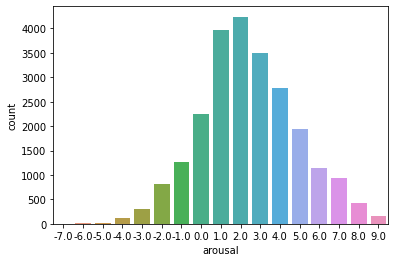

In [ ]:
sns.countplot(x=df_train['arousal'])

<AxesSubplot:xlabel='valence', ylabel='count'>

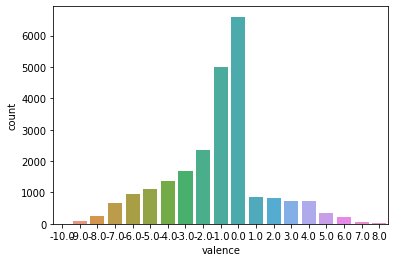

In [ ]:
sns.countplot(x=df_train['valence'])

## Concretization the targets for resampling

In [18]:
def concretize_targets(targets, unique_targets):
  concretized_targets = []
  for ar,va in targets:
    for i in range(0, len(unique_targets)):
      if(ar == unique_targets[i][0] and va == unique_targets[i][1]):
        concretized_targets.append(i)
        break

  return np.array(concretized_targets)

In [19]:
def extract_ar_va_from_dict(conretized_targets, unique_targets):
  targets = []

  for conretized_value in conretized_targets:
    targets.append(unique_targets[conretized_value])

  return (np.array(targets))/10.0

In [20]:
def remove_outlier_samples(data, concreted_targets):
  unique, counts = np.unique(concreted_targets, return_counts=True)
  outlier_values = []

  for count_index in np.where(counts <= 5)[0]:
    outlier_values.append(unique[count_index])

  removed_indexes = []

  for value in outlier_values:

    for index in np.where(concreted_targets == value)[0]:
      removed_indexes.append(index)

  processed_data = np.delete(data, removed_indexes, axis=0)
  processed_concreted_targets = np.delete(concreted_targets, removed_indexes, axis=0)

  return np.array(processed_data), np.array(processed_concreted_targets)

# Models

## Loss and hypeparameters

In [21]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [24]:
learning_rate = 0.001
epochs = 40
batch_size = 128

## Baseline Model

In [25]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(W,H,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 32x32x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 16x16x32

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2, activation='linear'))

    model.compile(loss = 'mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer = Adam(learning_rate))

    x_train = train_data[train_index]
    y_train = train_targets[train_index]

    x_val = train_data[val_index]
    y_val = train_targets[val_index]/10.0

    x_train = np.array(x_train)
    y_train = np.array(y_train)/10.0

    # Training step
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=es, verbose=1, validation_data=(x_val, y_val), shuffle=True)

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

    model.save('models/grayImagesModel_' + str(i) + '.h5')
    i=i+1

150/150 [==============================] - 6s 37ms/step - loss: 0.6780 - root_mean_squared_error: 0.7494 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3459


In [26]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

0.27117213010787966
0.08287717550992965
[0.07529883831739426, 0.057345494627952576, 0.07588155567646027, 0.08621891587972641, 0.11964107304811478]


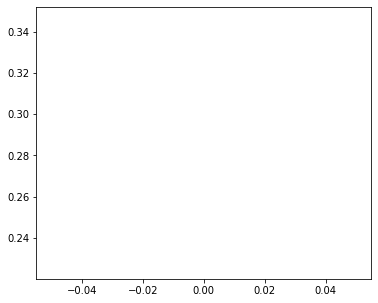

In [27]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_root_mean_squared_error'], color='g')
plt.show()

Test root mean squared error loss: 0.3498940972404755


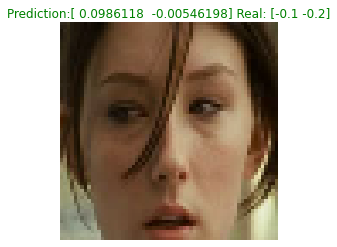

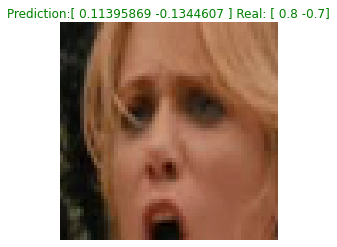

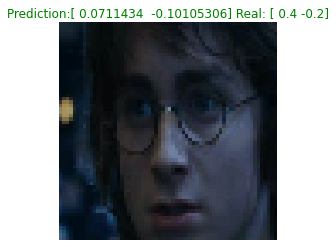

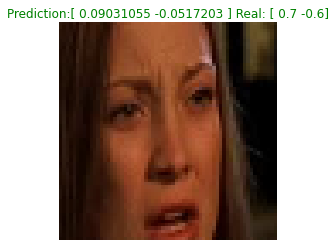

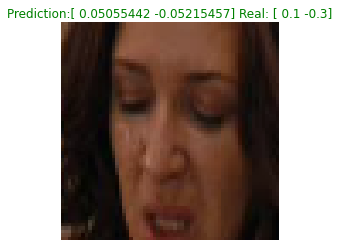

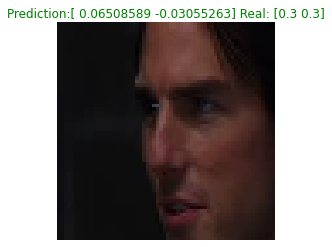

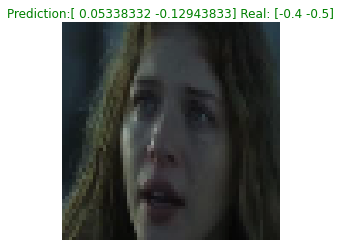

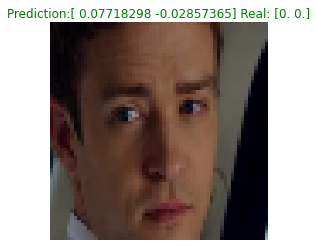

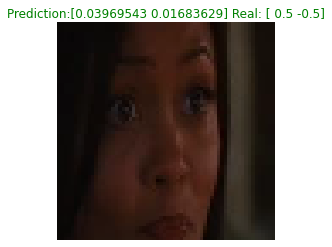

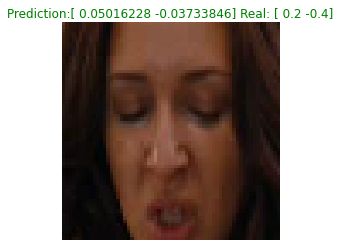

In [28]:
test_preds = model.predict(test_data)
test_loss = np.mean(root_mean_squared_error(test_targets, test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num]), color='g')

### Resampling

#### Arousal Estimation model with resampling

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(W,H,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 32x32x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 16x16x32

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='linear'))

    model.compile(loss = 'mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer = Adam(learning_rate))

    # Extracting arousal values
    x_train = train_data[train_index]
    y_train = train_targets[train_index][:,0]

    x_val = train_data[val_index]
    y_val = train_targets[val_index][:,0]/10.0

    # Resampling step
    smt = SMOTE(k_neighbors=2)

    full_data = np.reshape(x_train, (x_train.shape[0],W*H*3))

    smote_data, y_train = smt.fit_resample(full_data, y_train)

    x_train = np.reshape(smote_data, (smote_data.shape[0],W,H,3))

    x_train = np.array(x_train)
    y_train = np.array(y_train)/10.0

    # Training step
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=es, verbose=1, validation_data=(x_val, y_val), shuffle=True)

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

    model.save('models/grayImagesArousalModel_' + str(i) + '.h5')
    i=i+1

Epoch 1/40
429/429 [==============================] - 14s 30ms/step - loss: 0.3995 - root_mean_squared_error: 0.6321 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2717
Epoch 2/40
429/429 [==============================] - 12s 27ms/step - loss: 0.0709 - root_mean_squared_error: 0.2663 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2531
Epoch 3/40
429/429 [==============================] - 12s 29ms/step - loss: 0.0479 - root_mean_squared_error: 0.2190 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2465
Epoch 4/40
429/429 [==============================] - 13s 31ms/step - loss: 0.0366 - root_mean_squared_error: 0.1912 - val_loss: 0.0543 - val_root_mean_squared_error: 0.2331
Epoch 5/40
429/429 [==============================] - 12s 28ms/step - loss: 0.0295 - root_mean_squared_error: 0.1719 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2421
Epoch 6/40
429/429 [==============================] - 11s 27ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574 - val_loss: 0

In [29]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

0.27117213010787966
0.08287717550992965
[0.07529883831739426, 0.057345494627952576, 0.07588155567646027, 0.08621891587972641, 0.11964107304811478]


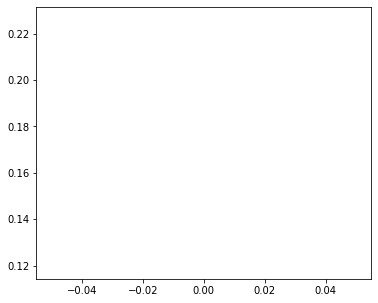

In [30]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

Test root mean squared error loss: 0.26590996295308184


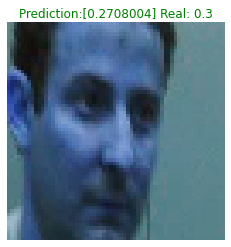

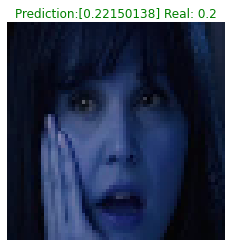

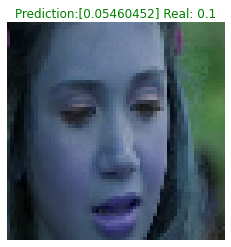

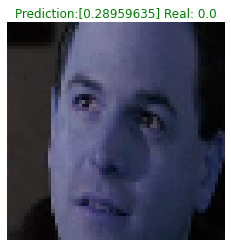

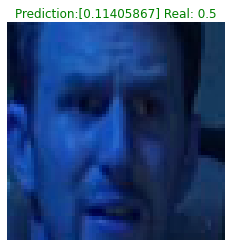

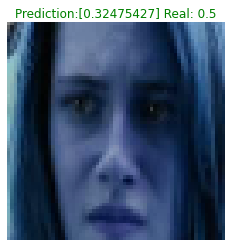

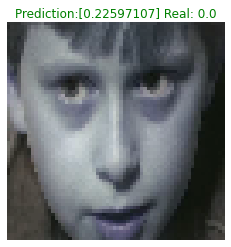

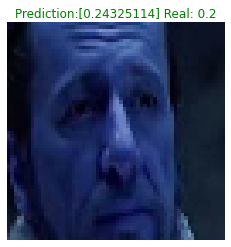

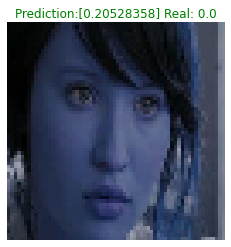

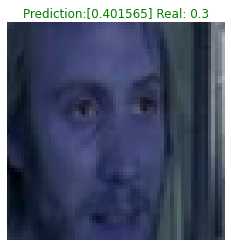

In [ ]:
test_preds = model.predict(test_data)
test_loss = np.mean(root_mean_squared_error(test_targets[:,0], test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num][0]), color='g')

#### Valence Estimation model with resampling

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(W,H,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 32x32x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 16x16x32

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='linear'))

    model.compile(loss = 'mse', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer = Adam(learning_rate))

    # Extracting valence values
    x_train = train_data[train_index]
    y_train = train_targets[train_index][:,1]

    x_val = train_data[val_index]
    y_val = train_targets[val_index][:,1]/10.0

    # Resampling step
    smt = SMOTE()

    full_data = np.reshape(x_train, (x_train.shape[0],W*H*3))

    smote_data, y_train = smt.fit_resample(full_data, y_train)

    x_train = np.reshape(smote_data, (smote_data.shape[0],W,H,3))

    x_train = np.array(x_train)
    y_train = np.array(y_train)/10.0

    # Training step
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=es, verbose=1, validation_data=(x_val, y_val), shuffle=True)

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

    model.save('models/grayImagesValenceModel_' + str(i) + '.h5')
    i=i+1
    break

Epoch 1/40
731/731 [==============================] - 29s 27ms/step - loss: 0.1996 - root_mean_squared_error: 0.4468 - val_loss: 0.1117 - val_root_mean_squared_error: 0.3342
Epoch 2/40
731/731 [==============================] - 19s 27ms/step - loss: 0.0530 - root_mean_squared_error: 0.2301 - val_loss: 0.1245 - val_root_mean_squared_error: 0.3529
Epoch 3/40
731/731 [==============================] - 19s 26ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3389
Epoch 4/40
731/731 [==============================] - 19s 26ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3347
Epoch 5/40
731/731 [==============================] - 19s 26ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460 - val_loss: 0.1093 - val_root_mean_squared_error: 0.3306
Epoch 6/40
731/731 [==============================] - 19s 27ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

0.0073692696169018745
0.09158123284578323
[0.09158123284578323]


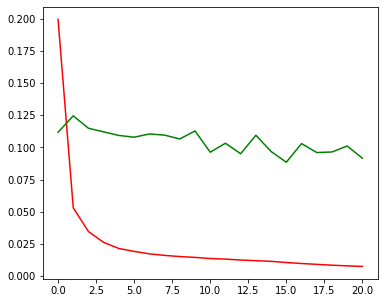

In [ ]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [31]:
test_preds = model.predict(test_data)
test_loss = np.mean(root_mean_squared_error(test_targets[:,1], test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num][1]), color='g')

ValueError: operands could not be broadcast together with shapes (1973,2) (1973,) 

## Landmark Integrated Model

### Load landmarks

In [ ]:
landmarks_data_train = []
landmarks_data_test = []

for face in train_data:
  landmarks_data_train.append(get_landmarks_as_face(face))

for face in test_data:
  landmarks_data_test.append(get_landmarks_as_face(face))

landmarks_data_train = np.array(landmarks_data_train)
landmarks_data_test = np.array(landmarks_data_test)

### Training

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', patience=5, mode='min')
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(W,H,4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 32x32x16

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    #model.add(MaxPool2D(strides=(2,2)))
    model.add(AvgPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    #Output dimension: 16x16x32

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2, activation='linear'))

    model.compile(loss = 'mse', metrics=[RootMeanSquaredError()], optimizer = Adam(learning_rate))

    x_train = np.concatenate([train_data[train_index], landmarks_data_train[train_index]], axis=3)
    y_train = train_targets[train_index]/10.0

    x_val = np.concatenate([train_data[val_index], landmarks_data_train[val_index]], axis=3)
    y_val = train_targets[val_index]/10.0

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=es, verbose=1, validation_data=(x_val, y_val), shuffle=True)

    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

    model.save('models/2layersModel_' + str(i) + '.h5')
    i=i+1
    break

Epoch 1/40
148/148 [==============================] - 16s 40ms/step - loss: 0.8732 - root_mean_squared_error: 0.9345 - val_loss: 0.0771 - val_root_mean_squared_error: 0.2777
Epoch 2/40
148/148 [==============================] - 5s 31ms/step - loss: 0.0451 - root_mean_squared_error: 0.2125 - val_loss: 0.0804 - val_root_mean_squared_error: 0.2835
Epoch 3/40
148/148 [==============================] - 5s 34ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0813 - val_root_mean_squared_error: 0.2851
Epoch 4/40
148/148 [==============================] - 5s 32ms/step - loss: 0.0284 - root_mean_squared_error: 0.1686 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2855
Epoch 5/40
148/148 [==============================] - 5s 33ms/step - loss: 0.0245 - root_mean_squared_error: 0.1564 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2834
Epoch 6/40
148/148 [==============================] - 5s 34ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0764

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

0.009048347361385822
0.07656671851873398
[0.07656671851873398]


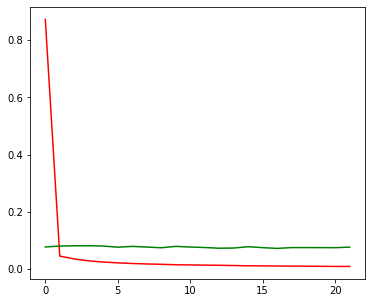

In [ ]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

Test root mean squared error loss: 0.25022622253242405


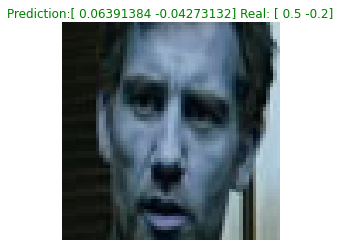

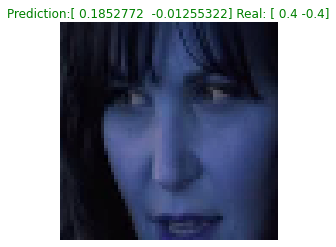

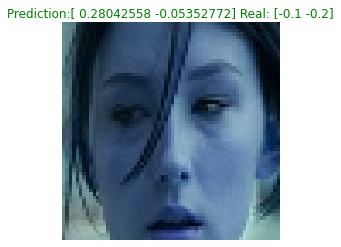

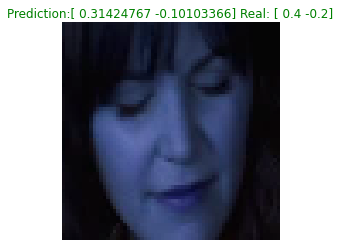

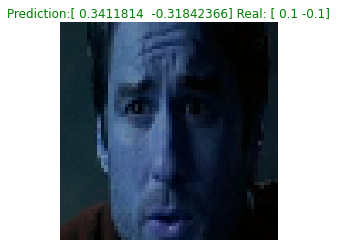

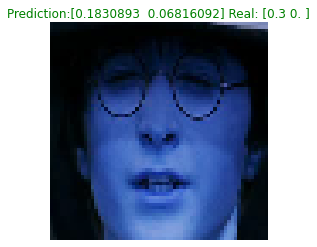

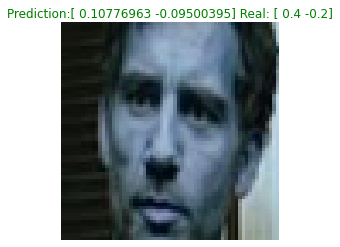

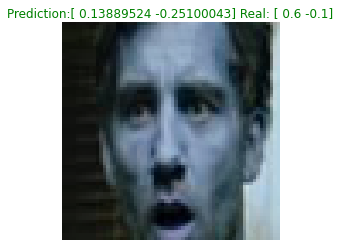

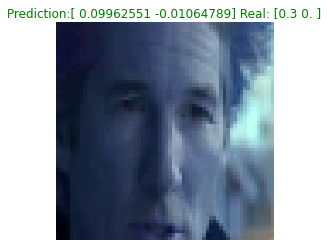

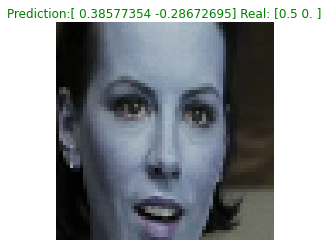

In [ ]:
test_preds = model.predict(np.concatenate([test_data, landmarks_data_test], axis=3))
test_loss = np.mean(root_mean_squared_error(test_targets, test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num]), color='g')

## Landmark Integrated Latent Model

In [ ]:
learning_rate = 0.001
epochs = 40
batch_size = 128

### Load landmarks

In [ ]:
def get_only_landmarks(face):
    landmarks = predictor(face, dlib.rectangle(0,0,W-1,H-1))
    list_landmarks = []
    for i in range(0, 68):
        list_landmarks.append(landmarks.part(i).x)
        list_landmarks.append(landmarks.part(i).y)
  
    return list_landmarks

In [ ]:
landmarks_data_train = []
landmarks_data_test = []

for face in train_data:
  landmarks_data_train.append(get_only_landmarks(face))

for face in test_data:
  landmarks_data_test.append(get_only_landmarks(face))

landmarks_data_train = np.array(landmarks_data_train)
landmarks_data_test = np.array(landmarks_data_test)

### Training

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', patience=5, mode='min')
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):
  img_input = Input((64,64,3))
    
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(img_input)
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  flatten_layer = Flatten()(cnnLayers)

  landmarks_input = Input((68*2))

  concatenate_layer = concatenate([flatten_layer, landmarks_input])

  dense = Dense(1024, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.25) (dense)
  dense = Dense(512, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.4) (dense)
  output = Dense(2, activation='linear')(dense)

  model = Model(inputs=[img_input, landmarks_input], outputs=output)
  model.compile(loss = 'mse', metrics=[RootMeanSquaredError()], optimizer = Adam(learning_rate))

  x_img_train = train_data[train_index]
  x_landmark_train = landmarks_data_train[train_index]
  y_train = train_targets[train_index]/10.0

  x_img_val = train_data[val_index]
  x_landmark_val = landmarks_data_train[val_index]
  y_val = train_targets[val_index]/10.0

  history = model.fit(x=[x_img_train, x_landmark_train], y=y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1, validation_data= ([x_img_val, x_landmark_val], y_val))

  loss.append(history.history['loss'][-1])
  val_loss.append(history.history['val_loss'][-1])

  model.save('models/concatenatedModel_' + str(i) + '.h5')
  i=i+1

0.04125053584575653
0.07745340093970299
[0.0838281512260437, 0.04815872386097908, 0.06752829253673553, 0.08876295387744904, 0.09898888319730759]


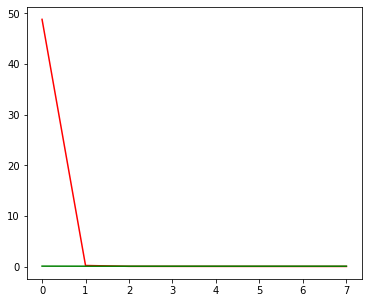

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

Test root mean squared error loss: 0.27084859006184847


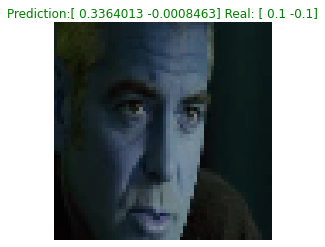

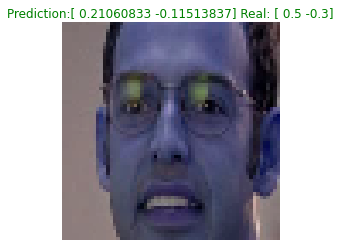

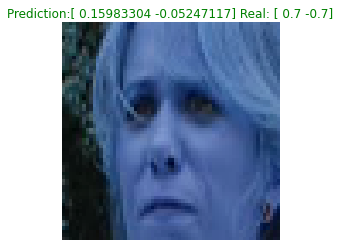

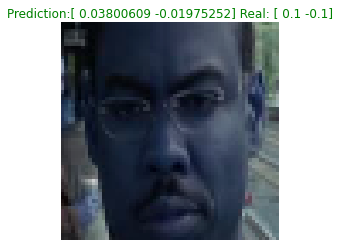

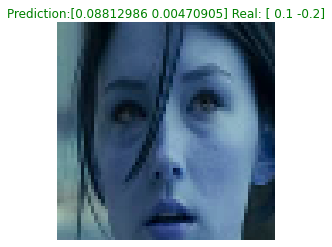

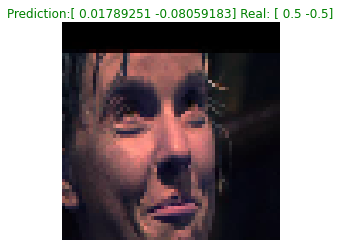

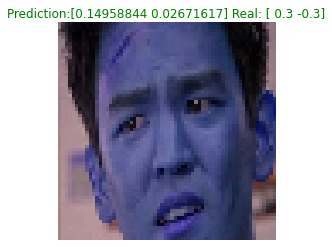

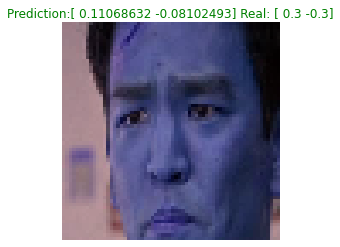

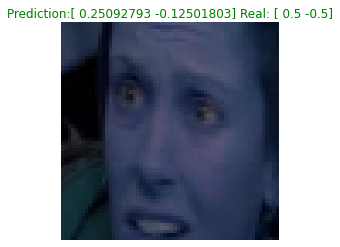

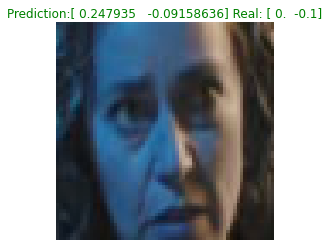

In [ ]:
test_preds = model.predict([test_data, landmarks_data_test])
test_loss = np.mean(root_mean_squared_error(test_targets, test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num]), color='g')

### Resampling

#### Arousal estimation model

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', patience=5, mode='min')
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):
  img_input = Input((64,64,1))
    
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(img_input)
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  flatten_layer = Flatten()(cnnLayers)

  landmarks_input = Input((68*2))

  concatenate_layer = concatenate([flatten_layer, landmarks_input])

  dense = Dense(1024, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.25) (dense)
  dense = Dense(512, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.4) (dense)
  output = Dense(1, activation='linear')(dense)

  model = Model(inputs=[img_input, landmarks_input], outputs=output)
  model.compile(loss = 'mse', metrics=[RootMeanSquaredError()], optimizer = Adam(learning_rate))

  x_img_train = train_data[train_index]
  x_landmark_train = landmarks_data_train[train_index]
  y_train = train_targets[train_index][:,0]

  x_img_val = train_data[val_index]
  x_landmark_val = landmarks_data_train[val_index]
  y_val = train_targets[val_index][:,0]/10.0

  # Resampling step
  smt = SMOTE()

  full_data = np.concatenate([np.reshape(x_img_train, (x_img_train.shape[0],W*H)), x_landmark_train], axis=1)

  full_data, y_train = remove_outlier_samples(full_data, y_train)

  smote_data, y_train = smt.fit_resample(full_data, y_train)

  x_img_train = np.reshape(smote_data[:,:-136], (smote_data.shape[0],W,H,1))
  x_landmark_train = np.reshape(smote_data[:,-136:], (smote_data.shape[0],136))

  y_train = np.array(y_train)/10.0

  # Training step
  history = model.fit(x=[x_img_train, x_landmark_train], y=y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1, validation_data= ([x_img_val, x_landmark_val], y_val))

  loss.append(history.history['loss'][-1])
  val_loss.append(history.history['val_loss'][-1])

  model.save('models/arousalConcatenatedModel_' + str(i) + '.h5')
  i=i+1
  break;

Epoch 1/40
411/411 [==============================] - 37s 58ms/step - loss: 33.5718 - root_mean_squared_error: 5.7941 - val_loss: 0.0624 - val_root_mean_squared_error: 0.2499
Epoch 2/40
411/411 [==============================] - 23s 55ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 3/40
411/411 [==============================] - 23s 55ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2602
Epoch 4/40
411/411 [==============================] - 23s 57ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2483
Epoch 5/40
411/411 [==============================] - 23s 56ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2464
Epoch 6/40
411/411 [==============================] - 23s 55ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919 - val_loss: 

0.0216622706502676
0.05606820434331894
[0.05606820434331894]


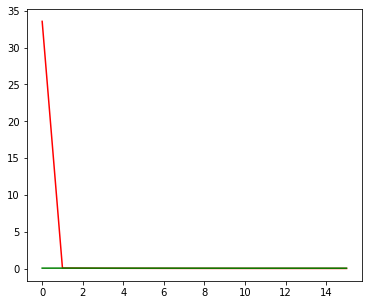

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

Test root mean squared error loss: 0.24972811853912633


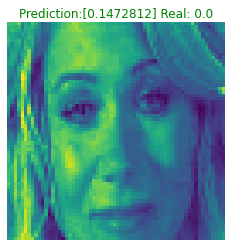

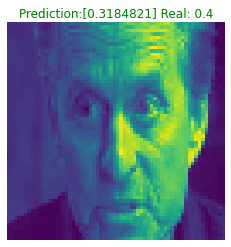

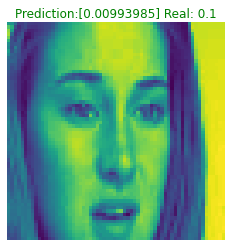

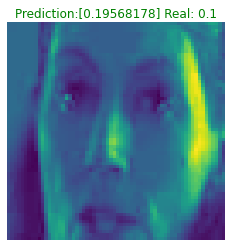

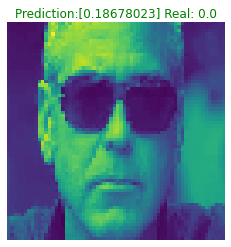

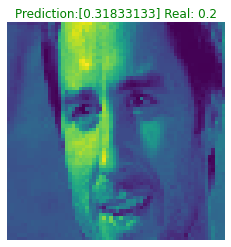

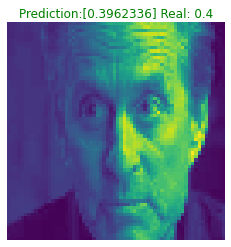

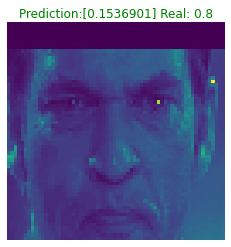

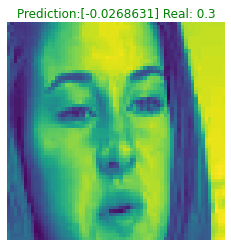

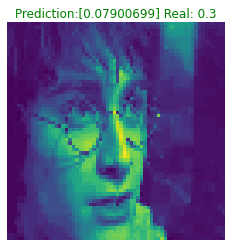

In [ ]:
test_preds = model.predict([test_data, landmarks_data_test])
test_loss = np.mean(root_mean_squared_error(test_targets[:,0], test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num][0]), color='g')

In [ ]:
np.min(test_preds)

0.78555804

#### Valence estimation model

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', patience=5, mode='min')
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):
  img_input = Input((64,64,1))
    
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(img_input)
  cnnLayers = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(cnnLayers)
  cnnLayers = BatchNormalization()(cnnLayers)

  cnnLayers = AvgPool2D(strides=(2,2))(cnnLayers)
  cnnLayers = Dropout(0.25) (cnnLayers)

  flatten_layer = Flatten()(cnnLayers)

  landmarks_input = Input((68*2))

  concatenate_layer = concatenate([flatten_layer, landmarks_input])

  dense = Dense(1024, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.25) (dense)
  dense = Dense(512, activation = 'relu') (concatenate_layer)
  dense = Dropout(0.4) (dense)
  output = Dense(1, activation='linear')(dense)

  model = Model(inputs=[img_input, landmarks_input], outputs=output)
  model.compile(loss = 'mse', metrics=[RootMeanSquaredError()], optimizer = Adam(learning_rate))

  x_img_train = train_data[train_index]
  x_landmark_train = landmarks_data_train[train_index]
  y_train = train_targets[train_index][:,1]

  x_img_val = train_data[val_index]
  x_landmark_val = landmarks_data_train[val_index]
  y_val = train_targets[val_index][:,1]/10.0

  # Resampling step
  smt = SMOTE()

  full_data = np.concatenate([np.reshape(x_img_train, (x_img_train.shape[0],W*H)), x_landmark_train], axis=1)

  full_data, y_train = remove_outlier_samples(full_data, y_train)

  smote_data, y_train = smt.fit_resample(full_data, y_train)

  x_img_train = np.reshape(smote_data[:,:-136], (smote_data.shape[0],W,H,1))
  x_landmark_train = np.reshape(smote_data[:,-136:], (smote_data.shape[0],136))

  y_train = np.array(y_train)/10.0

  # Training step
  history = model.fit(x=[x_img_train, x_landmark_train], y=y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1, validation_data= ([x_img_val, x_landmark_val], y_val))

  loss.append(history.history['loss'][-1])
  val_loss.append(history.history['val_loss'][-1])

  model.save('models/valenceConcatenatedModel_' + str(i) + '.h5')
  i=i+1
  break;

Epoch 1/40
721/721 [==============================] - 50s 56ms/step - loss: 13.7179 - root_mean_squared_error: 3.7038 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3684
Epoch 2/40
721/721 [==============================] - 40s 55ms/step - loss: 0.0637 - root_mean_squared_error: 0.2524 - val_loss: 0.1380 - val_root_mean_squared_error: 0.3715
Epoch 3/40
721/721 [==============================] - 39s 55ms/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.1270 - val_root_mean_squared_error: 0.3564
Epoch 4/40
721/721 [==============================] - 39s 55ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 5/40
721/721 [==============================] - 39s 55ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.1084 - val_root_mean_squared_error: 0.3292
Epoch 6/40
721/721 [==============================] - 39s 55ms/step - loss: 0.0355 - root_mean_squared_error: 0.1883 - val_loss: 

0.0201664250344038
0.10241574048995972
[0.10241574048995972]


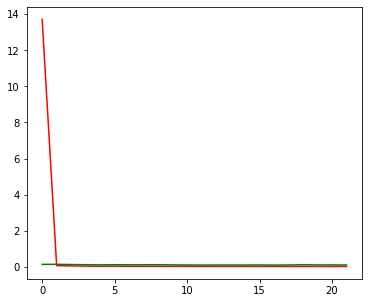

In [ ]:
print(np.mean(loss))
print(np.mean(val_loss))
print(val_loss)

plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

Test root mean squared error loss: 0.2958706683665572


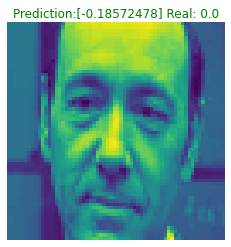

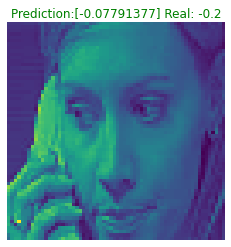

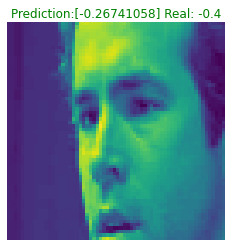

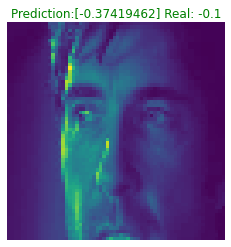

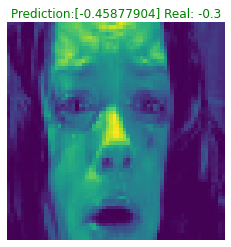

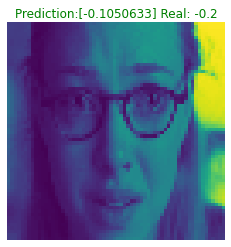

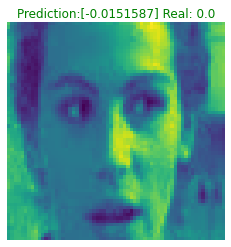

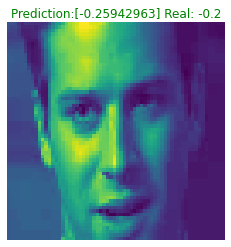

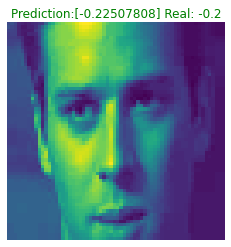

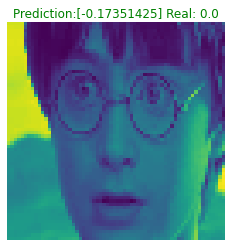

In [ ]:
test_preds = model.predict([test_data, landmarks_data_test])
test_loss = np.mean(root_mean_squared_error(test_targets[:,1], test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num][1]), color='g')

In [ ]:
np.max(test_preds)

0.22015597

## Transfer learning

### VGG16_VA

In [ ]:
train_data_processed = preprocess_input(train_data)
test_data_processed = preprocess_input(test_data)

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(W,H,3))
base_model.trainable = False

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dropout_1 = layers.Dropout(0.25)
dense_layer_2 = layers.Dense(512, activation='relu')
dropout_2 = layers.Dropout(0.4)
prediction_layer = layers.Dense(2, activation='linear')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_1,
    dense_layer_2,
    dropout_2,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer= Adam(learning_rate),
    loss= 'mse',
    metrics=[RootMeanSquaredError()]
)

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=5,  restore_best_weights=True)
# mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

i = 0

for train_index, val_index in kf.split(train_data):

  x_train = train_data_processed[train_index]
  y_train = train_targets[train_index]/10.0

  x_val = train_data_processed[val_index]
  y_val = train_targets[val_index]/10.0

  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], validation_data=(x_val, y_val), shuffle=True)

  model.save('models/VGGdModel_' + str(i) + '.h5')
  i=i+1

Epoch 1/40
146/146 [==============================] - 30s 138ms/step - loss: 14.7541 - root_mean_squared_error: 3.8411 - val_loss: 0.0969 - val_root_mean_squared_error: 0.3114
Epoch 2/40
146/146 [==============================] - 18s 123ms/step - loss: 0.1462 - root_mean_squared_error: 0.3823 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3049
Epoch 3/40
146/146 [==============================] - 18s 124ms/step - loss: 0.1083 - root_mean_squared_error: 0.3290 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2917
Epoch 4/40
146/146 [==============================] - 18s 124ms/step - loss: 0.0951 - root_mean_squared_error: 0.3084 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2878
Epoch 5/40
146/146 [==============================] - 18s 124ms/step - loss: 0.0879 - root_mean_squared_error: 0.2965 - val_loss: 0.0814 - val_root_mean_squared_error: 0.2853
Epoch 6/40
146/146 [==============================] - 18s 123ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_

Test root mean squared error loss: 0.2393093744919121


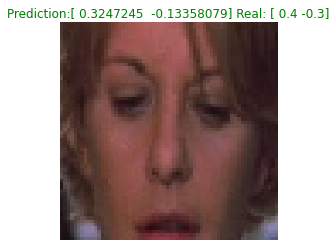

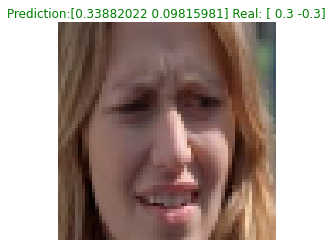

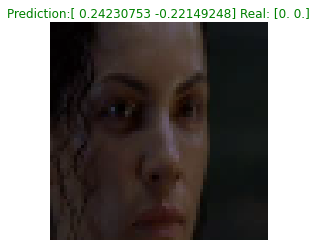

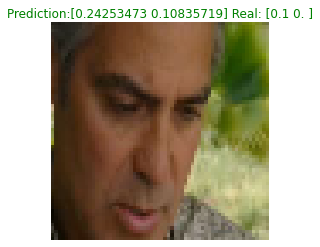

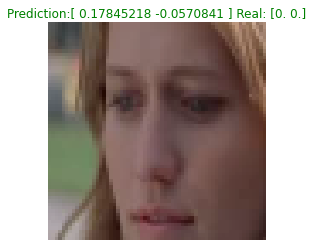

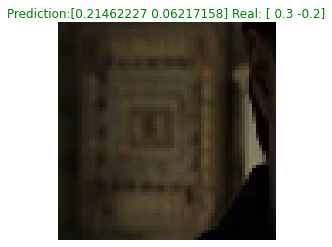

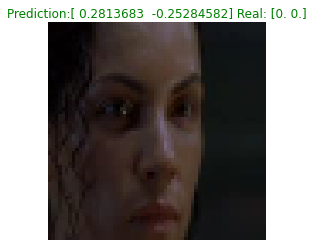

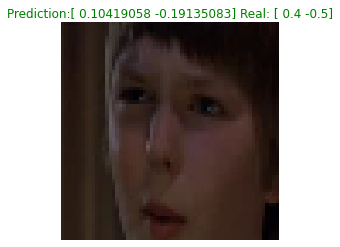

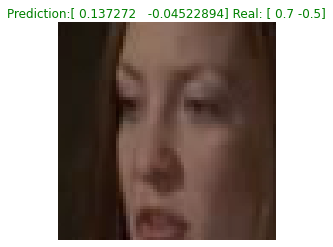

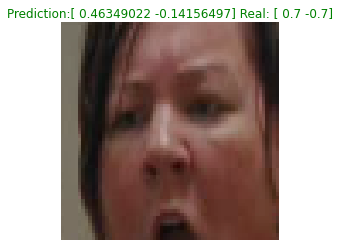

In [ ]:
test_preds = model.predict(test_data_processed)
test_loss = np.mean(root_mean_squared_error(test_targets, test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num]), color='g')

### ResNet50_VA

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(W,H,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
  layer.trainable = False

In [ ]:
model = Sequential()
model.add(restnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='linear'))

In [ ]:
kf = KFold(n_splits=5)

loss = []
val_loss = []

es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=5,  restore_best_weights=True)

i = 0

for train_index, val_index in kf.split(train_data):

  x_train = train_data_processed[train_index]
  y_train = train_targets[train_index]/10.0

  x_val = train_data_processed[val_index]
  y_val = train_targets[val_index]/10.0

  model.compile(optimizer=Adam(learning_rate),loss= 'mse',metrics = [RootMeanSquaredError()])

  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], validation_data=(x_val, y_val), shuffle=True)
  model.save('models/ResNetModel_' + str(i) + '.h5')
  i=i+1

Epoch 1/40
146/146 [==============================] - 24s 127ms/step - loss: 6.4934 - root_mean_squared_error: 2.5482 - val_loss: 0.0897 - val_root_mean_squared_error: 0.2995
Epoch 2/40
146/146 [==============================] - 16s 109ms/step - loss: 0.0955 - root_mean_squared_error: 0.3091 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 3/40
146/146 [==============================] - 16s 108ms/step - loss: 0.0815 - root_mean_squared_error: 0.2855 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2827
Epoch 4/40
146/146 [==============================] - 16s 109ms/step - loss: 0.0733 - root_mean_squared_error: 0.2707 - val_loss: 0.0770 - val_root_mean_squared_error: 0.2775
Epoch 5/40
146/146 [==============================] - 16s 108ms/step - loss: 0.0661 - root_mean_squared_error: 0.2572 - val_loss: 0.0791 - val_root_mean_squared_error: 0.2812
Epoch 6/40
146/146 [==============================] - 16s 108ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_l

Test root mean squared error loss: 0.22083836197888343


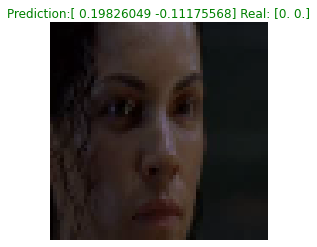

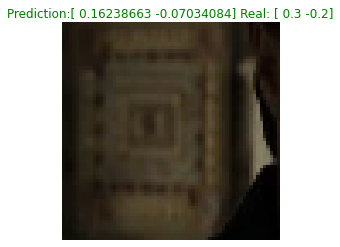

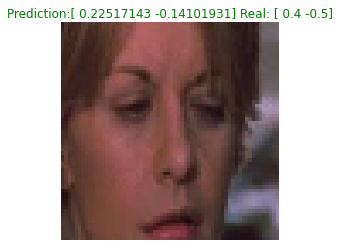

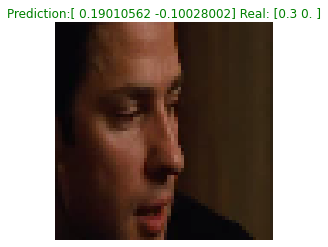

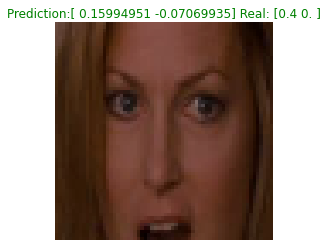

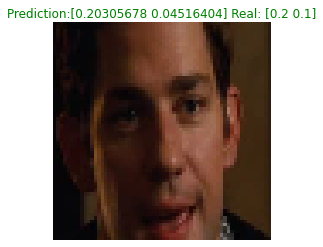

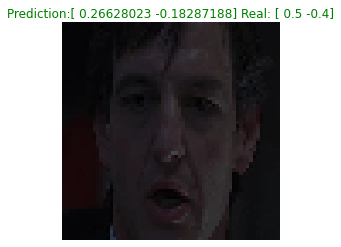

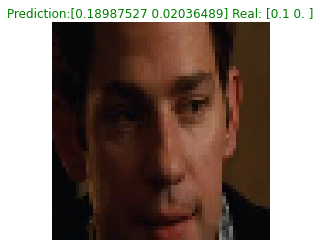

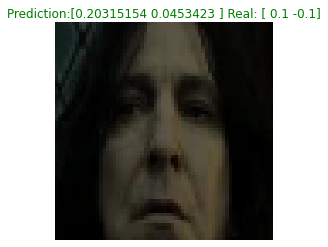

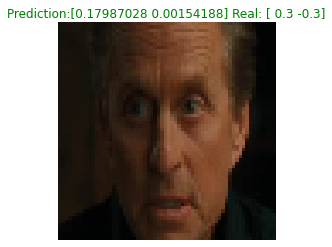

In [ ]:
test_preds = model.predict(test_data_processed)
test_loss = np.mean(root_mean_squared_error(test_targets, test_preds))
print('Test root mean squared error loss:',test_loss)

for rand_num in np.random.randint(0, len(test_data), 10):
    plt.figure()
    plt.imshow(test_data[rand_num].reshape(W, H, 3))
    plt.axis('off')
    plt.title('Prediction:' + str(test_preds[rand_num]) + ' Real: ' + str(test_targets[rand_num]), color='g')